#d

### seq2seq의 문제점

- seq2seq은 Encoder가 문장을 '고정 길이'의 벡터로 변환해서 Decoder에 전달함.  
문장 길이와 관계 없이 '고정 길이'로 변환하기 때문에 긴 문장의 경우 필요한 정보가 다 담기지 못하는 문제가 발생함.


### Endoder 개선
- 개선 방법으로, 각 단어 (시각)별 hidden state $h$를 모두 출력($hs$)
<br/> <img src='../figs/fig%208-2.png'> <br/>
- 이 떄, 각 시각의 $h$에는 직전에 입력된 단어(Encoder의 input)에 대한 정보가 많이 포함되어 있음.

### Decoder 개선
- Encoder가 각 단어에 대응하는 LSTM layer의 hidden state $h$를 모아서 $hs$로 출력해서 Decoder에 전달하면, Decoder는 $hs$를 다시 문장으로 변환함.
<br/> <img src='../figs/fig%208-4.png'> <br/>
- 이 과정에서 '입력과 출력의 여러 단어 중 어떤 단어끼리 서로 관련되어 있는가?'(alignment)를 학습시키고자 함.  
'도착어 단어'(I)와 대응 관계에 있는 '출발어 단어'(나)의 정보를 골라내기 위해 Attention 매커니즘을 사용

#### Weighted Sum
- Decoder의 각 시각마다, 입력된 단어와 대응 관계인 단어의 벡터를 $hs$에서 골라내고자 함.  
그러나 $hs$에서 벡터를 선택하는 작업은 미분할 수 없기 때문에 back-propagation을 위해 미분 가능한 연산으로 대체
- 각 단어의 중요도를 나타내는 가중치 $a$와 각 단어의 벡터 $hs$로부터 weighted sum을 구하여 맥락 벡터 $c$를 얻음
<br/> <img src='../figs/fig%208-8.png'> <br/>
- $c$에 현 시각의 변환을 수행하는데 필요한 정보(단어간의 대응 관계, alignment)가 담기는 방향으로 학습

In [1]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
    
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)
        
        return dhs, da

#### a를 구하는 방법
- Decoder의 LSTM layer의 $h$가 Encoder의 출력 $hs$의 각 단어 벡터와 얼마나 '비슷한지'를 수치로 나타내서 가중치로 이용.  
- $h$와 $hs$의 내적을 통해 유사도 점수 $s$를 구하고, Softmax를 통해 정규화해서 가중치 $a$를 구함.
<br/> <img src='../figs/fig%208-15.png'> <br/>

In [2]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
        
    def forward(self, hs, h):
        N, T, H = hs.shape
        
        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)
        
        self.cache = (hs, hr)
        
        return a
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape
        
        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt*hr
        dhr = dt*hs
        dh = np.sum(dhr, axis=1)
        
        return dhs, dh

#### 결합
- 위에서 구현한 Weight Sum, Attention Weight를 하나로 결합.
<br/> <img src='../figs/fig%208-16.png'> <br/>
- Attention Weight layer가 Encoder의 출력 $hs$에 주목하여 각 단어의 가중치 $a$를 구하고, $a$와 $hs$의 Weighted Sum을 통해 맥락 벡터 $c$를 구함
- 이 과정을 수행하는 layer를 Attention layer라고 부름.


In [4]:
 class Attention:
        def __init__(self):
            self.params, self.grads = [], []
            self.attention_weight_layer = AttentionWeight()
            self.weight_sum_layer = WeightSum()
            self.attention_weight = None
            
        def forward(self, hs, h):
            a = self.attention_weight_layer.forward(hs, h)
            out = self.weight_sum_layer.forward(hs, a)
            self.attention_weight = a
            
            return out
        
        def backward(self, dout):
            dhs0, da = self.weight_sum_layer.backward(dout)
            dhs1, dh = self.attention_weight_layer.backward(da)
            dhs = dhs0 + dhs1
            
            return dhs, dh      

- 앞선 layer들과 마찬가지로 Time Attention layer 구현

In [32]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None
        
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
            
        return out
    
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh
            
        return dhs_enc, dhs_dec

-  기존 Affine layer와 LSTM layer 사이에 Attention layer를 넣어서 Decoder에 어텐션 정보를 추가

### Attention을 포함한 seq2seq 구현
- 앞에서 구현해놓은 Enccoder에서 LSTM layer의 마지막 $h$만 반환하던 것에서 모든 $h$를 반환하는 것으로 변경

In [33]:
sys.path.append('../code/seq2seq')
from seq2seq import Encoder, Seq2seq
from common.time_layers import *

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs
    
    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

- Decoder의 경우 

In [34]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        embed_W = (rn(V, D)/100).astype('f')
        lstm_Wx = (rn(D, 4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(2*H, V)/np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        # attention layer 추가
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]
        
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
    
    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        # attention layer를 통해 c 계산
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)
        
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


- 위 Attention Encoder와 Attention Decoder를 결합하여 Attention Seq2seq 구현

In [35]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 날짜 형식 변환 문제
- 날짜 형식 변환 문제를 통해 위에서 구현한 Attention seq2seq의 성능을 평가해 볼 것.
<br/> <img src='../figs/fig%208-22.png'> <br/>

In [36]:
from data import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import PeekySeq2seq

In [37]:
# data load
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# reverse
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# hyperparameter 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [38]:
acc_list = []

for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, 
               batch_size=batch_size, max_grad=max_grad)
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, 
                                   id_to_char, verbose, is_reverse=True)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    
    print(f'val acc : {acc*100}')
    

model.save_params()
        
        

| epoch 1 |  itr 1/351 | time 0.8640406131744385[s] | loss 4.07801399230957
| epoch 1 |  itr 21/351 | time 11.422736883163452[s] | loss 3.0866257762908935
| epoch 1 |  itr 41/351 | time 22.832525730133057[s] | loss 1.9038669395446781
| epoch 1 |  itr 61/351 | time 36.30640697479248[s] | loss 1.7195860290527343
| epoch 1 |  itr 81/351 | time 49.66436815261841[s] | loss 1.4629032897949221
| epoch 1 |  itr 101/351 | time 63.245250940322876[s] | loss 1.1921350669860842
| epoch 1 |  itr 121/351 | time 76.58332061767578[s] | loss 1.1404548883438113
| epoch 1 |  itr 141/351 | time 89.89800238609314[s] | loss 1.0911264801025393
| epoch 1 |  itr 161/351 | time 103.42958426475525[s] | loss 1.0587649583816527
| epoch 1 |  itr 181/351 | time 116.96468448638916[s] | loss 1.0406064891815185
| epoch 1 |  itr 201/351 | time 131.3544158935547[s] | loss 1.0313516998291017
| epoch 1 |  itr 221/351 | time 146.01213383674622[s] | loss 1.024596667289734
| epoch 1 |  itr 241/351 | time 159.63236451148987[s] 

Q sunday, november 6, 2016     
T 2016-11-06
O 2016-11-06
---
val acc : 99.9
| epoch 5 |  itr 1/351 | time 0.7998595237731934[s] | loss 0.002182954549789429
| epoch 5 |  itr 21/351 | time 14.485414505004883[s] | loss 0.003950979998335242
| epoch 5 |  itr 41/351 | time 28.03149437904358[s] | loss 0.0022091213706880806
| epoch 5 |  itr 61/351 | time 40.81390619277954[s] | loss 0.002172183776274324
| epoch 5 |  itr 81/351 | time 53.58927607536316[s] | loss 0.003606102243065834
| epoch 5 |  itr 101/351 | time 66.24373602867126[s] | loss 0.0022468312736600637
| epoch 5 |  itr 121/351 | time 79.92574143409729[s] | loss 0.001824158634990454
| epoch 5 |  itr 141/351 | time 93.21198749542236[s] | loss 0.003313454454764724
| epoch 5 |  itr 161/351 | time 106.89377331733704[s] | loss 0.0018006361741572617
| epoch 5 |  itr 181/351 | time 119.78692197799683[s] | loss 0.0017814536439254875
| epoch 5 |  itr 201/351 | time 133.1482982635498[s] | loss 0.0016665066312998532
| epoch 5 |  itr 221/351 | ti

Q october 6, 1992              
T 1992-10-06
O 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
O 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
O 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
O 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
O 2016-11-06
---
val acc : 99.96000000000001
| epoch 9 |  itr 1/351 | time 0.6941773891448975[s] | loss 0.0005494490731507539
| epoch 9 |  itr 21/351 | time 13.683534860610962[s] | loss 0.0004045340430457145
| epoch 9 |  itr 41/351 | time 27.168009519577026[s] | loss 0.0012456762092188
| epoch 9 |  itr 61/351 | time 41.42052435874939[s] | loss 0.00036094885435886684
| epoch 9 |  itr 81/351 | time 54.842023849487305[s] | loss 0.00037857426330447204
| epoch 9 |  itr 101/351 | time 68.6961567401886[s] | loss 0.0003691952303051949
| epoch 9 |  itr 121/351 | time 82.85506916046143[s] | loss 0.00032679145690053704
| epoch 9 |  itr 141/351 | time 96.64045763015747[s] | loss 0.0003528160671703518
| epoch 9

In [40]:
import matplotlib.pyplot as plt

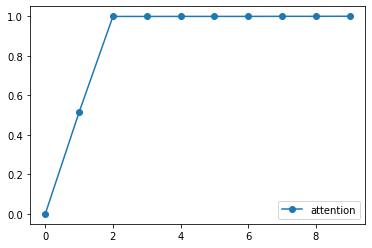

In [45]:
plt.plot(acc_list, '-o', label='attention')
plt.legend()
plt.show()

In [46]:
1

1